# Setup


In [2]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import ceil
from datetime import datetime, timedelta
import scipy
from scipy.stats import pearsonr, norm
from statsmodels.formula.api import ols
from os import listdir
from collections import defaultdict
from functools import partial
from json import dumps, loads
from tensorflow.keras.losses import MAPE

palette = partial(sns.color_palette, "colorblind")


In [262]:
if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip().replace('\\', '/')
        tbl_dir = f"{fig_dir.rsplit('/', maxsplit=2)[0]}/Tables/"
else:
    fig_dir = 'Figures/'
    tbl_dir = 'Tables/'

def trim_trailing_zeros(number_string):
    '''
    Take a string with numbers and remove any trailing zeros from the number.
    '''
    return sub(
        r'(?:\.0+|(\.\d+)0+)(%?)$', 
        '\\1\\2', number_string
    )

def neaten_ticks(
        ax, axis, tick_range, ticks, dp=0, fmt='f', twin=False, commas=False, hide_tick_range=False):
    '''
    Take a plot ax and convert its x or y axis into a neatened range frame.
    '''
    # Set sets.
    if hide_tick_range:
        ticks = sorted(ticks)
    else:
        ticks = sorted([*ticks, *tick_range])
    eval(f"ax.set_{axis}ticks")(ticks)
    is_log = eval(f"ax.get_{axis}scale")() == 'log' 
    # Set labels.
    eval(f"ax.set_{axis}ticklabels")([
        f"$\\mathdefault{{10^{{{ex:.0f}}}}}$" 
        if is_log and int((ex := np.log10(e))) == ex 
        else trim_trailing_zeros(eval(f'''f"{{e:{',' if commas else ''}.0{dp}{fmt}}}"'''))
        for e in eval(f"ax.get_{axis}ticks")()
    ])
    # Limit axis outline to data range.
    ax.spines[
        'right' if twin else 'bottom' if axis == 'x' else 'left'
    ].set_bounds(*tick_range)

def show(
    fig, axes=[], tight=False, despine=True, despine_twin=False, 
    delax=True, file=None, legend_loc=0, style_legend=True, filetype='pdf'
):
    '''Style and show a matplotlib plot.'''
    if tight: plt.tight_layout() # Neaten subplots.
    # Remove unnecessary outlines from plots with twin axes.
    # Note that this method assumes all axes have twins.
    if despine_twin:
        for ax in axes[::2]:
            ax.spines['top'].set_visible(False)
            # ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
        for ax in axes[1::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    # Remove unnecessary outlines.
    elif despine:
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    for ax in axes:
    # Remove unused subplots.
        if delax and not ax.has_data(): fig.delaxes(ax)
        ax.tick_params(
            axis='both', which='minor', 
            bottom=False, left=False, right=False
        )
        # Style the legend if permitted and a legend is present.
        if ax.get_legend() and style_legend:
            handles, labels = ax.get_legend_handles_labels()
            labels = [e.title() for e in labels]
            legend_title = ax.get_legend().get_title().get_text().title()
            ax.legend(
                handles=handles, labels=labels, 
                title=legend_title, loc=legend_loc
            )
    # Save file if a filename is provided.
    if file:
        plt.savefig(
            f'{fig_dir}/Plots/{file}.{filetype}', dpi = 300,
            bbox_inches = 'tight', pad_inches = 1/25
        )
    plt.show()

def to_model_label(name):
    label = 'Multivariate ' if 'multiv' in name else 'Univariate '
    label += 'Deep ' if 'deep' in name else 'Shallow '
    label += 'MLP' if 'MLP' in name else 'BD-LSTM'
    return label


# Learning rate experiment summary

In [271]:
lr_smry_df = pd.read_csv('Results/lr scheduler comparison on shallow MLP.csv')

lr_smry_df = lr_smry_df.melt(id_vars='function', var_name='Step', value_name='MAPE')
lr_smry_df.function = lr_smry_df.function.apply(lambda e: sub(r'.*(\d)', r'$f_\1$', e))
lr_smry_df.Step = lr_smry_df.Step.apply(lambda e: sub(r'.*?(\d+)', r'\1 hour', e))

lr_smry_df


,function,Step,MAPE
0,$f_1$,1 hour,1.234822
1,$f_1$,1 hour,1.084792
2,$f_1$,1 hour,1.160965
3,$f_1$,1 hour,1.068854
4,$f_1$,1 hour,1.082540
...,...,...,...
75,$f_4$,24 hour,3.811834
76,$f_4$,24 hour,3.856075
77,$f_4$,24 hour,4.101814
78,$f_4$,24 hour,3.876484


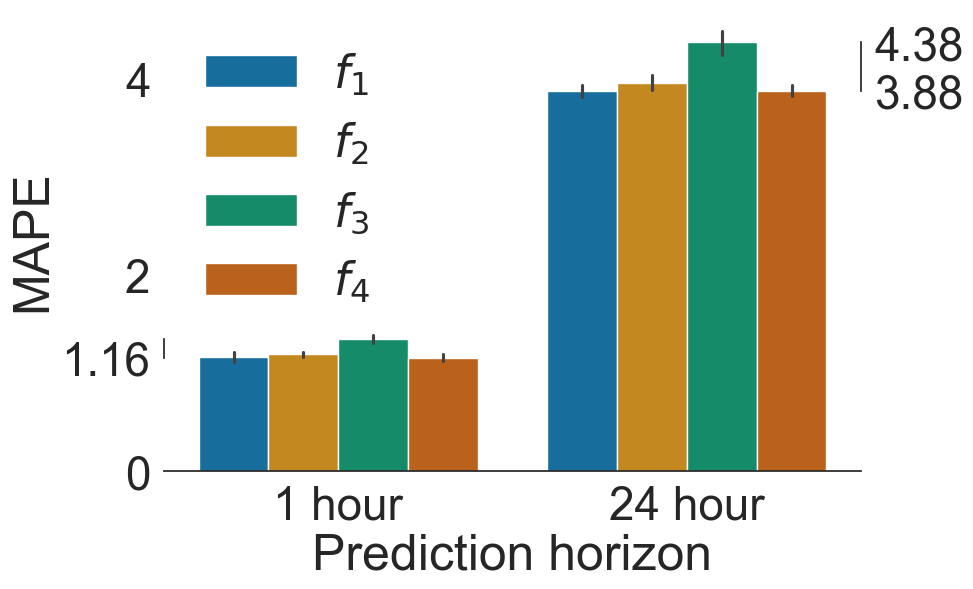

In [273]:
fig, ax = plt.subplots(figsize=(9, 6))

line = sns.barplot(data=lr_smry_df, x='Step', y='MAPE', hue='function', palette=palette(lr_smry_df.function.nunique()))
line.set_label('Label via method')

h1_means = lr_smry_df[lr_smry_df.Step == '1 hour'].groupby(['function']).MAPE.mean()
neaten_ticks(ax, 'y', [h1_means.min(), h1_means.max()], [0, h1_means.min(), 2, 4], dp=2, hide_tick_range=True)

ax2 = ax.twinx()
h24_means = lr_smry_df[lr_smry_df.Step == '24 hour'].groupby(['function']).MAPE.mean()
neaten_ticks(ax2, 'y', [h24_means.min(), h24_means.max()], [], dp=2, twin=True)
ax2.set_ylim(*ax.get_ylim())

ax.tick_params(axis='both', color='white')
ax2.tick_params(axis='both', color='white')

ax.set_xlabel('Prediction horizon')

legend = line.legend(loc=2)
legend.get_frame().set_alpha(0)


show(fig, [ax, ax2], delax=False, despine_twin=True, style_legend=False, file='LR scheduling experiment results')


In [275]:
# from scipy.stats import ttest_ind

# for stp in lr_smry_df.Step.unique():
#     x = lr_smry_df[(
#         (lr_smry_df.function.isin(['scheduler4']))
#         & (lr_smry_df.Step == stp)
#     )].MAPE
#     y = lr_smry_df[(
#         (lr_smry_df.function.isin(['scheduler2']))
#         & (lr_smry_df.Step == stp)
#     )].MAPE
#     print(ttest_ind(x, y, equal_var=False, alternative='less').pvalue)


In [189]:
def ci(data: pd.Series, alpha=0.05):
    return norm.ppf(.975) * data.std(ddof=0) / len(data)**.5

with open('Results/lr scheduler comparison on shallow MLP.json', 'r') as f:
    lr_res = pd.DataFrame(loads(f.read()))

lr_res_df = pd.DataFrame()

for col in lr_res:
    xx = lr_res[col].apply(pd.Series).loss.apply(pd.Series).agg(['mean', ci]).T
    yy = lr_res[col].apply(pd.Series).val_loss.apply(pd.Series).agg(['mean', ci]).T
    for i, zz in enumerate([xx, yy]):
        zz['upper'] = zz['mean'] + zz.ci
        zz['lower'] = zz['mean'] - zz.ci
        zz = zz.drop(columns=['ci'])
        zz['set'] = 'validation' if i else 'train'
        zz['function'] = col
        zz['epoch'] = zz.index + 1
        lr_res_df = pd.concat([lr_res_df, zz]).reset_index(drop=True)

lr_res_df.function = lr_res_df.function.apply(lambda e: sub(r'.*(\d)', r'$f_\1$', e))

lr_res_df


,mean,upper,lower,set,function,epoch
0,99.903358,99.919843,99.886872,train,scheduler1,1
1,99.568192,99.635720,99.500663,train,scheduler1,2
2,98.016785,98.286571,97.746999,train,scheduler1,3
3,94.006918,94.743375,93.270462,train,scheduler1,4
4,86.196698,87.666146,84.727250,train,scheduler1,5
...,...,...,...,...,...,...
15995,2.508362,2.545373,2.471352,validation,scheduler4,1996
15996,2.508346,2.545364,2.471328,validation,scheduler4,1997
15997,2.508301,2.545298,2.471304,validation,scheduler4,1998
15998,2.508275,2.545282,2.471268,validation,scheduler4,1999


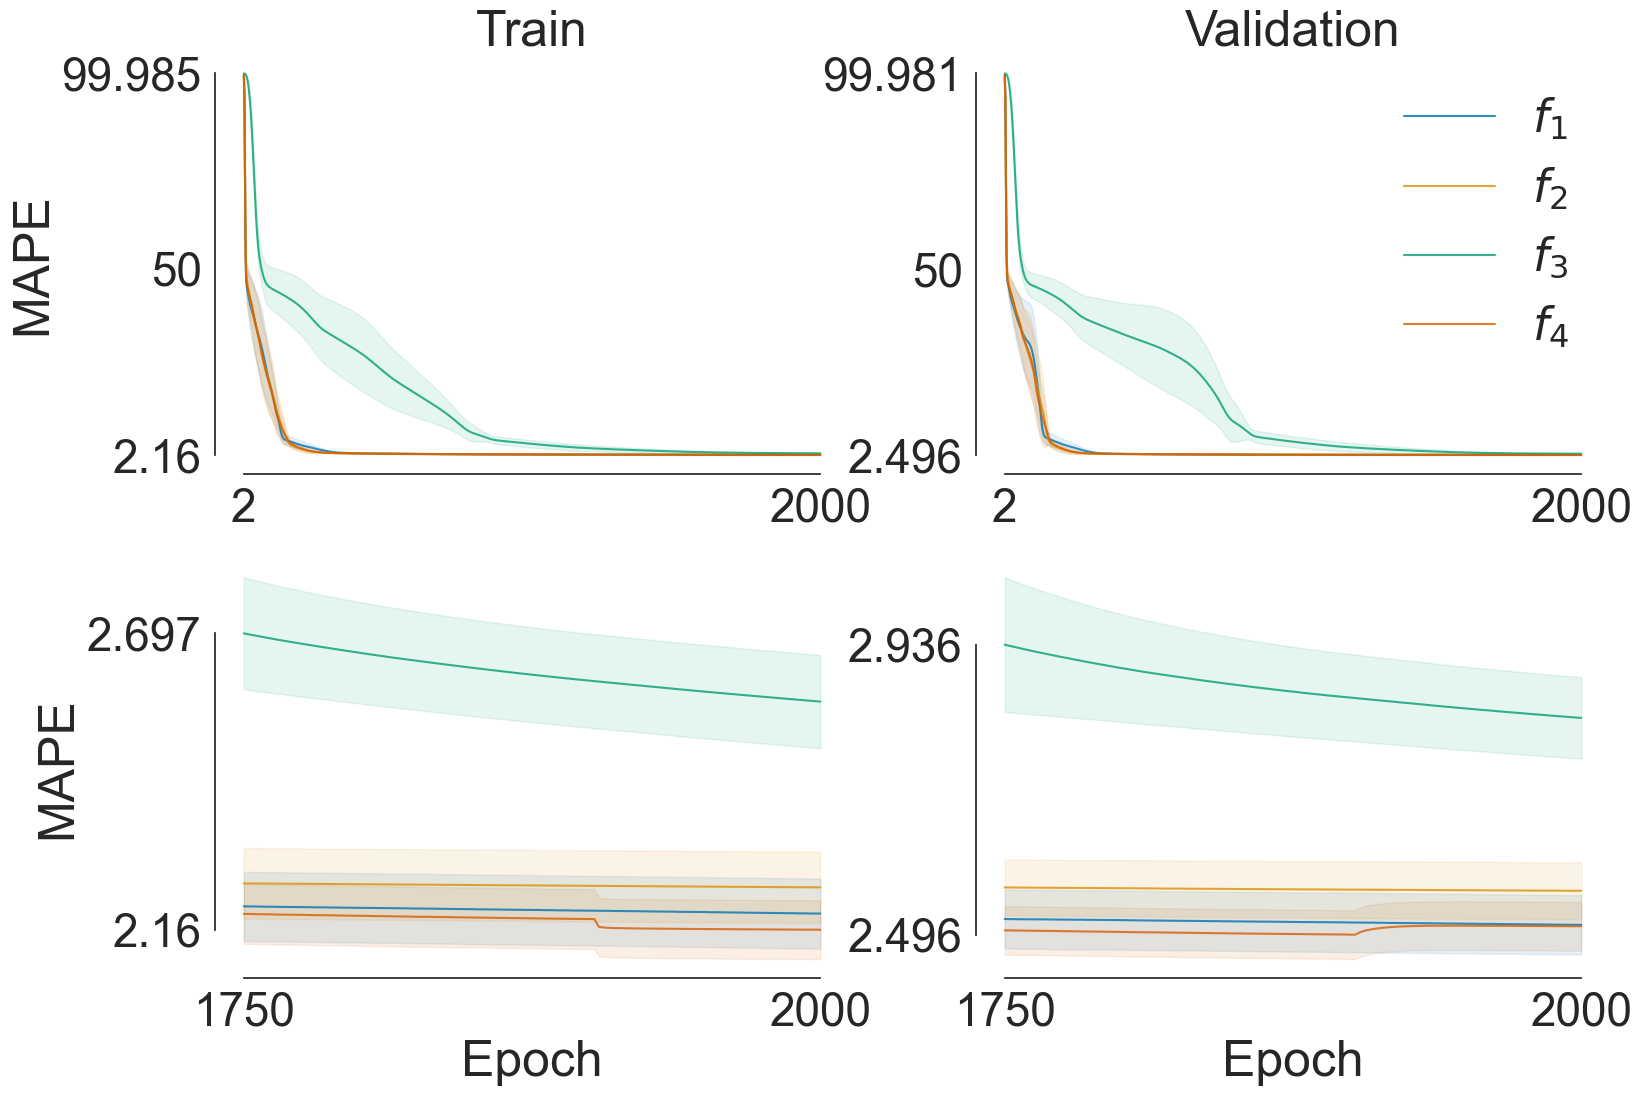

In [282]:
cols = lr_res_df.set.unique()
n_col, n_row = len(cols), 2

fig, axes = plt.subplots(n_row, n_col, figsize=(9*n_col, 6*n_row))
axes = axes.flatten()
fill = palette(lr_res_df.function.nunique())

for i in range(n_col*n_row):
    ax, col = axes[i], cols[i % 2]

    data=lr_res_df[(
        (lr_res_df.set == col)
        & (lr_res_df.index % 2 == 1)
     )]
    if i >= 2:
        yticks = []
        data = data[data.epoch >= 1750]
        title, xlabel, ylabel = '', 'Epoch', ''
    else:
        yticks = [50]
        title, xlabel, ylabel = col.title(), '', ''
    if i % 2 == 0:
        ylabel = 'MAPE'

    line = sns.lineplot(
        ax=ax, data=data, x='epoch', y='mean', hue='function', 
        palette=fill, alpha=0.8
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for j, fnct in enumerate(data.function.unique()):
        data_f = data[data.function == fnct]
        ax.fill_between(
            data_f.epoch, 
            data_f.upper, 
            data_f.lower, 
            alpha=0.1,
            color=fill[j]
        )

    data_s = data[data.set == col]
    ax.set_yticks([])
    neaten_ticks(ax, 'y', [data_s['mean'].min(), data_s['mean'].max()], yticks, dp=3)
    neaten_ticks(ax, 'x', [data_s.epoch.min(), data_s.epoch.max()], [])

    if i != 1:
        ax.get_legend().remove()
    else:
        legend = line.legend()
        legend.get_frame().set_alpha(0)

        
    ax.tick_params(axis='both', color='white')


show(fig, axes, style_legend=False, file='LR scheduling experiment training histories')


# ~~Weight decay experiment summary~~

In [9]:
wd_smry_df = pd.read_csv('Results/weight decay comparison on shallow MLP.csv')

wd_smry_df = wd_smry_df.melt(id_vars='weight_decay', var_name='Step', value_name='MAPE')

wd_smry_df


,weight_decay,Step,MAPE
0,0.00000,H1,1.076746
1,0.00000,H1,1.245005
2,0.00000,H1,1.213953
3,0.00000,H1,1.251266
4,0.00000,H1,1.223955
...,...,...,...
75,0.00001,H24,4.104717
76,0.00001,H24,4.071819
77,0.00001,H24,4.041662
78,0.00001,H24,3.816740


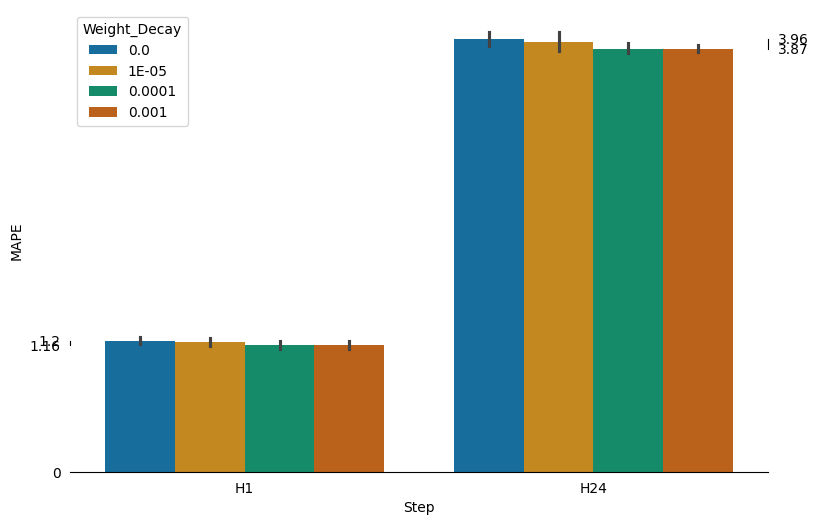

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(data=wd_smry_df, x='Step', y='MAPE', hue='weight_decay', palette=palette(wd_smry_df.weight_decay.nunique()))

h1_means = wd_smry_df[wd_smry_df.Step == 'H1'].groupby(['weight_decay']).MAPE.mean()
neaten_ticks(ax, 'y', [h1_means.min(), h1_means.max()], [0], dp=2)

ax2 = ax.twinx()
h24_means = wd_smry_df[wd_smry_df.Step == 'H24'].groupby(['weight_decay']).MAPE.mean()
neaten_ticks(ax2, 'y', [h24_means.min(), h24_means.max()], [], dp=2, twin=True)
ax2.set_ylim(*ax.get_ylim())

ax.tick_params(axis='both', color='white')
ax2.tick_params(axis='both', color='white')

show(fig, [ax, ax2], delax=False, despine_twin=True)


In [11]:
with open('Results/weight decay comparison on shallow MLP.json', 'r') as f:
    wd_res = pd.DataFrame(loads(f.read()))

wd_res_df = pd.DataFrame()

for col in wd_res:
    xx = wd_res[col].apply(pd.Series).loss.apply(pd.Series).agg(['mean', ci]).T
    yy = wd_res[col].apply(pd.Series).val_loss.apply(pd.Series).agg(['mean', ci]).T
    for i, zz in enumerate([xx, yy]):
        zz['upper'] = zz['mean'] + zz.ci
        zz['lower'] = zz['mean'] - zz.ci
        zz = zz.drop(columns=['ci'])
        zz['set'] = 'validation' if i else 'train'
        zz['weight_decay'] = col
        zz['epoch'] = zz.index + 1
        wd_res_df = pd.concat([wd_res_df, zz]).reset_index(drop=True)
    
wd_res_df


,mean,upper,lower,set,weight_decay,epoch
0,99.895631,99.908109,99.883153,train,null,1
1,99.521867,99.579166,99.464568,train,null,2
2,97.826155,98.100566,97.551744,train,null,3
3,93.352706,94.141577,92.563835,train,null,4
4,85.312503,87.083900,83.541106,train,null,5
...,...,...,...,...,...,...
15995,2.548583,2.598394,2.498771,validation,1e-05,1996
15996,2.548572,2.598394,2.498751,validation,1e-05,1997
15997,2.548541,2.598384,2.498698,validation,1e-05,1998
15998,2.548528,2.598347,2.498710,validation,1e-05,1999


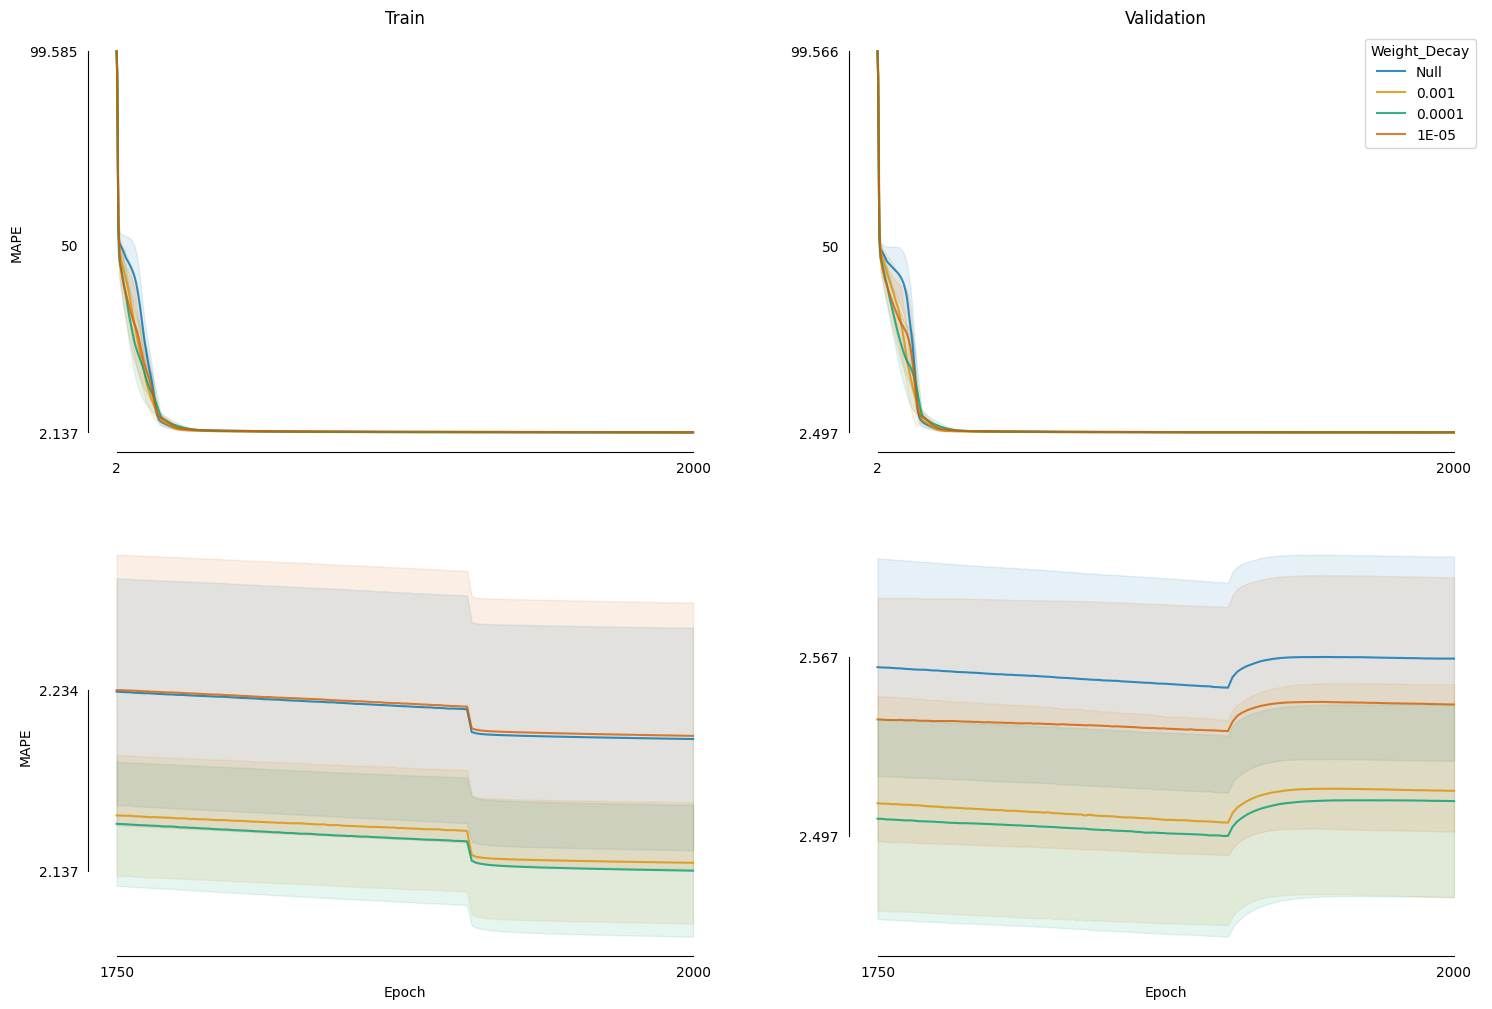

In [12]:
cols = wd_res_df.set.unique()
n_col, n_row = len(cols), 2

fig, axes = plt.subplots(n_row, n_col, figsize=(9*n_col, 6*n_row))
axes = axes.flatten()
fill = palette(wd_res_df.weight_decay.nunique())

for i in range(n_col*n_row):
    ax, col = axes[i], cols[i % 2]

    data=wd_res_df[(
        (wd_res_df.set == col)
        & (wd_res_df.index % 2 == 1)
     )]
    if i >= 2:
        yticks = []
        data = data[data.epoch >= 1750]
        title, xlabel, ylabel = '', 'Epoch', ''
    else:
        yticks = [50]
        title, xlabel, ylabel = col.title(), '', ''
    if i % 2 == 0:
        ylabel = 'MAPE'

    sns.lineplot(
        ax=ax, data=data, x='epoch', y='mean', hue='weight_decay', 
        palette=fill, alpha=0.8
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for j, fnct in enumerate(data.weight_decay.unique()):
        data_f = data[data.weight_decay == fnct]
        ax.fill_between(
            data_f.epoch, 
            data_f.upper, 
            data_f.lower, 
            alpha=0.1,
            color=fill[j]
        )

    data_s = data[data.set == col]
    ax.set_yticks([])
    neaten_ticks(ax, 'y', [data_s['mean'].min(), data_s['mean'].max()], yticks, dp=3)
    neaten_ticks(ax, 'x', [data_s.epoch.min(), data_s.epoch.max()], [])

    if i != 1:
        ax.get_legend().remove()
        
    ax.tick_params(axis='both', color='white')

show(fig, axes)


# Hyperparameter grid search

In [258]:
def format_batch_size(e, dollars=False):
    e_fmt = f"2^{{{np.log2(e):.0f}}}"
    if dollars:
        e_fmt = f"${e_fmt}$"
    return e_fmt

def format_weight_decay(e, dollars=False):
    e_fmt = f"10^{{-{f'{e:.09f}'.find('1')-1}}}"
    if dollars:
        e_fmt = f"${e_fmt}$"
    return e_fmt

param_grid = {
    'batch_size': [2**8, 2**9, 2**10],
    'optimizer__weight_decay': [1e-3, 1e-4, 1e-5],
    'optimizer__beta_1': [.8, .9, .95],
}

param_grid = pd.DataFrame(param_grid)

param_grid.batch_size = param_grid.batch_size.apply(format_batch_size)
param_grid.optimizer__weight_decay = param_grid.optimizer__weight_decay.apply(format_weight_decay)
param_grid.columns = [sub('_+', ' ', e).title().replace('Beta 1', '$\\beta_1$') for e in param_grid]

pgrid_tex = param_grid.apply(lambda d: f"$\\left[{', '.join([str(e) for e in d])}\\right]$")\
    .to_frame().reset_index()\
    .rename(columns={'index': 'Hyperparameter', 0: 'Values Searched'})\
    .style.hide()\
    .to_latex(
        label='param-grid', position_float="centering", hrules=True, position='H', column_format='lr',
        caption = f"The hyperparameter matrix used in the grid search. The optimiser values were passed to the Adam optimiser, and the batch size was passed to the models' fit methods."
    )

pgrid_tex = sub(r'(?s)(^.*)(\\caption{.*?}\n\\label{.*?}\n)(.*)(\\end{table})', r'\1\3\2\4', pgrid_tex)
print(pgrid_tex)

with open(f"{tbl_dir}parameter grid.tex", 'w') as f:
    f.write(pgrid_tex)


\begin{table}[H]
\centering
\begin{tabular}{lr}
\toprule
Hyperparameter & Values Searched \\
\midrule
Batch Size & $\left[2^{8}, 2^{9}, 2^{10}\right]$ \\
Optimizer Weight Decay & $\left[10^{-3}, 10^{-4}, 10^{-5}\right]$ \\
Optimizer $\beta_1$ & $\left[0.8, 0.9, 0.95\right]$ \\
\bottomrule
\end{tabular}
\caption{The hyperparameter matrix used in the grid search. The optimiser values were passed to the Adam optimiser, and the batch size was passed to the models' fit methods.}
\label{param-grid}
\end{table}



In [259]:
from collections import ChainMap

gsearch = []

for mdl in ['MLP', 'BD-LSTM']:
    with open(f'Results/{mdl} gridsearch results.json', 'r') as f: 
        gsearch.append({'model': mdl, **ChainMap(*loads(f.read()).values())})


gsearch_res = pd.DataFrame(gsearch)
gsearch_res.batch_size = gsearch_res.batch_size.apply(format_batch_size, dollars=True)
gsearch_res.weight_decay = gsearch_res.weight_decay.apply(format_weight_decay, dollars=True)

gsearch_res.columns = ['Model', *param_grid.columns]

gsearch_tex = gsearch_res.style.hide()\
    .format("{:.02f}", subset=gsearch_res.columns[-1])\
    .to_latex(
        label='gsearch-res', position_float="centering", hrules=True, position='H', column_format='lrrr',
        caption = f"The optimal hyperparameters for each model found in the grid search. The optimiser values were passed to the Adam optimiser, and the batch size was passed to the models' fit methods."
    )

gsearch_tex = sub(r'(?s)(^.*)(\\caption{.*?}\n\\label{.*?}\n)(.*)(\\end{table})', r'\1\3\2\4', gsearch_tex)
print(gsearch_tex)

with open(f"{tbl_dir}grid search results.tex", 'w') as f:
    f.write(gsearch_tex)



\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Model & Batch Size & Optimizer Weight Decay & Optimizer $\beta_1$ \\
\midrule
MLP & $2^{8}$ & $10^{-5}$ & 0.95 \\
BD-LSTM & $2^{8}$ & $10^{-5}$ & 0.80 \\
\bottomrule
\end{tabular}
\caption{The optimal hyperparameters for each model found in the grid search. The optimiser values were passed to the Adam optimiser, and the batch size was passed to the models' fit methods.}
\label{gsearch-res}
\end{table}



# Feature reduction results

In [13]:
with open('Results/MLP feature reduction results.json') as f:
    fr_res = loads(f.read())

print(fr_res['description'])
del fr_res['description']

fr_res = pd.DataFrame(fr_res).reset_index().rename(columns={'index': 'model'})

fr_res['n_variables'] = fr_res.variables.apply(len)

fr_res['train_time'] = fr_res[['train_time (us/step)', 'steps', 'epochs']].product(axis=1) / 60e6

fr_res


Tested prospects for reducing features through L1 regularisation of the kernel weights. Epsilon (e) is an arbitrary exclusion value. If the sum of the kernel weights for a variable are below or equal to e, the variable is dropped.


,model,MAPE_validation,train_time (us/step),steps,epochs,variables,n_variables,train_time
0,L1=0.1,4.6835,302.2650,512,2000,"[TOTALDEMAND, TEMPERATURE, year, month, day_of...",66,5.158656
1,L1=0.0,2.5784,302.5995,512,2000,"[TOTALDEMAND, TEMPERATURE, year, month, day_of...",66,5.164365
2,e>1e-3,2.8004,287.4855,512,2000,"[TOTALDEMAND, TEMPERATURE, period_of_day, is_p...",51,4.906419
3,e>1e-2,3.0079,276.6270,512,2000,"[TOTALDEMAND, TEMPERATURE, h24_day_of_week, TM...",19,4.721101


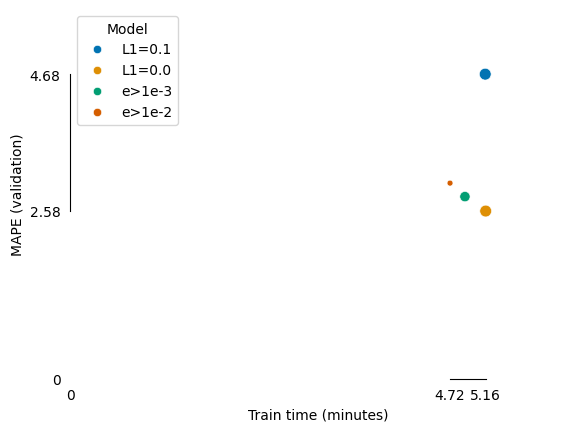

In [14]:
fig, ax = plt.subplots()

fr_plot = sns.scatterplot(fr_res, x='train_time', y='MAPE_validation', size='n_variables', hue='model', palette=palette(len(fr_res)))

ax.set_xlim(0, fr_res.train_time.max() + 1)
ax.set_ylim(0, fr_res.MAPE_validation.max() + 1)

ax.set_xlabel('Train time (minutes)')
ax.set_ylabel('MAPE (validation)')

neaten_ticks(ax, 'x', [fr_res.train_time.min(), fr_res.train_time.max()], [0], dp=2)
neaten_ticks(ax, 'y', [fr_res.MAPE_validation.min(), fr_res.MAPE_validation.max()], [0], dp=2)
ax.tick_params(axis='both', color='white')

plt.legend(title='Model', handles=fr_plot.get_children()[2:6])

show(fig, [ax], style_legend=False)


# Training times


In [4]:
ttimes = pd.read_csv('models/train_times.csv', parse_dates=['start_time'])
ttimes.train_time = ttimes.train_time.astype('timedelta64[ns]')
ttimes['total_minutes'] = ttimes.train_time.dt.total_seconds() / 60
ttimes['total_hours'] = ttimes.total_minutes / 60
ttimes['label'] = ttimes.model.apply(to_model_label)

ttimes


,model,start_time,train_time,epochs,steps,total_minutes,total_hours,label
0,Final_MLP_shallow_multiv,2024-04-11 23:28:57.676672,0 days 02:01:59.548757,10000,2456,121.992479,2.033208,Multivariate Shallow MLP
1,Final_MLP_deep_multiv,2024-04-12 01:30:58.811206,0 days 01:48:00.476131,4000,2456,108.007936,1.800132,Multivariate Deep MLP
2,Final_LSTM_shallow_multiv,2024-04-12 03:19:00.561206,0 days 02:08:37.538500,73,2456,128.625642,2.143761,Multivariate Shallow BD-LSTM
3,Final_LSTM_deep_multiv,2024-04-12 05:27:52.354039,0 days 01:59:34.425274,21,2456,119.573755,1.992896,Multivariate Deep BD-LSTM
4,Final_MLP_shallow_univ,2024-04-12 07:28:18.614487,0 days 01:57:50.300272,10500,2456,117.838338,1.963972,Univariate Shallow MLP
5,Final_MLP_deep_univ,2024-04-12 09:58:48.883013,0 days 01:44:32.686466,3950,2456,104.544774,1.742413,Univariate Deep MLP
6,Final_LSTM_shallow_univ,2024-04-12 11:43:22.791439,0 days 02:11:04.185515,105,2456,131.069759,2.184496,Univariate Shallow BD-LSTM
7,Final_LSTM_deep_univ,2024-04-12 13:54:37.849943,0 days 02:12:59.734693,30,2456,132.995578,2.216593,Univariate Deep BD-LSTM
8,Extended_Final_LSTM_deep_univ,2024-04-13 09:07:24.221449,0 days 04:54:25.200049,120,2456,294.420001,4.907000,Univariate Deep BD-LSTM
9,Extended_Final_LSTM_shallow_multiv,2024-04-13 13:11:03.177207,0 days 02:36:53.683472,146,2456,156.894725,2.614912,Multivariate Shallow BD-LSTM


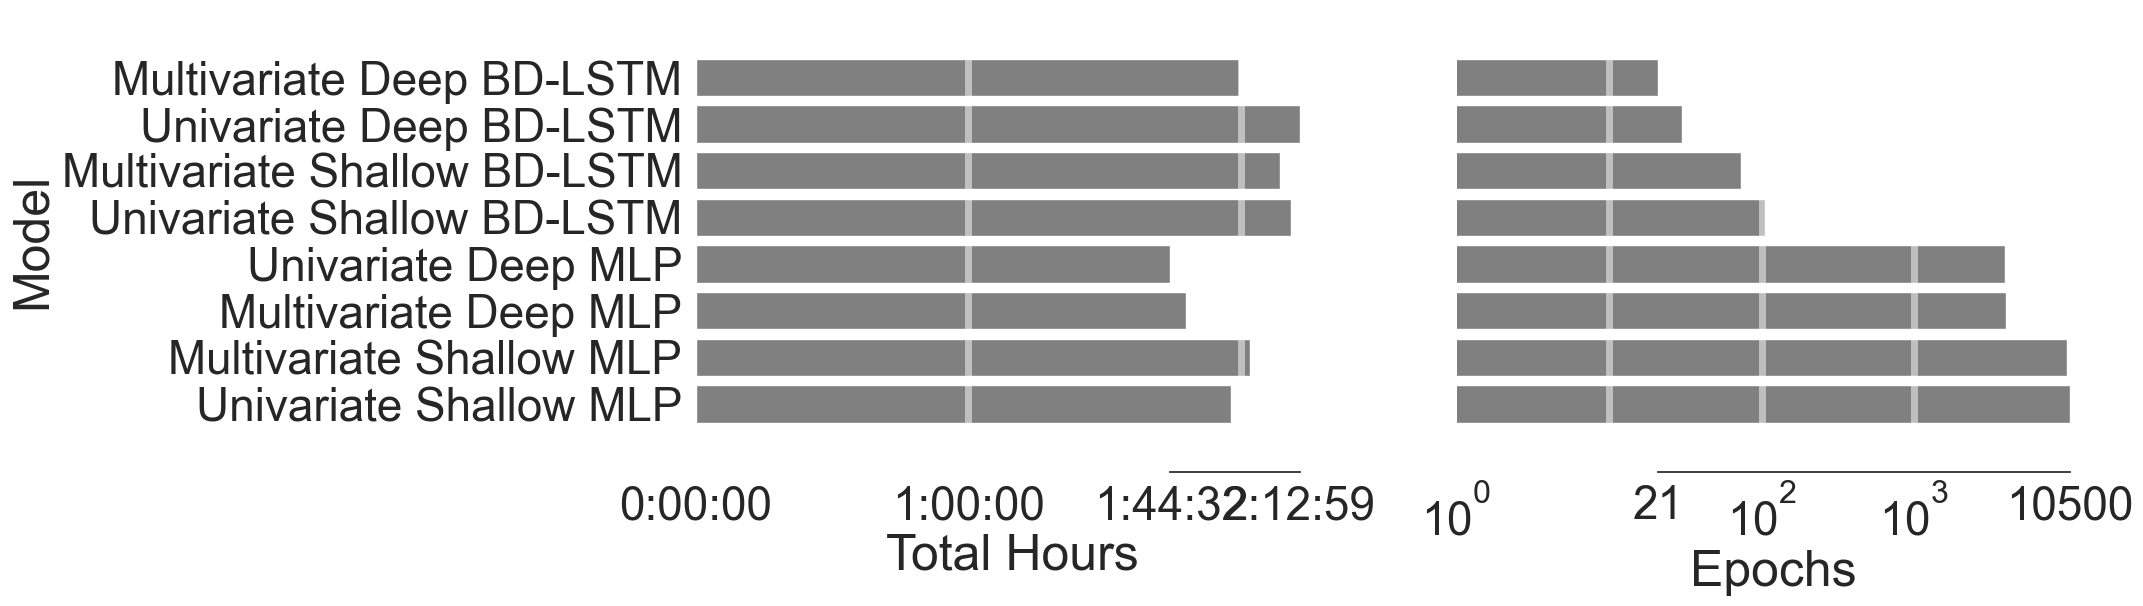

In [118]:
first_ttimes = ttimes[ttimes.model.str.match('^Final')].sort_values('epochs')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, col in enumerate(['total_hours', 'epochs']):
    ax = axes[i]

    sns.barplot(data=first_ttimes, x=col, y='label', ax=ax, color='grey')

    ax.tick_params(axis='both', color='white')
    ax.spines['left'].set_visible(False)

    ax.set_xlabel(col.replace('_', ' ').title())
    
    if i == 0:
        ax.set_ylabel('Model')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')

    if col == 'epochs':
        ax.set_xscale('log')
        ax.set_xlim(1)
        x_ticks = [1, 100, 1000]
        x_grid = [10, 100, 1000]
    else:
        x_ticks = [0, 1]
        x_grid = [1, 2]

    neaten_ticks(ax, 'x', [first_ttimes[col].min(), first_ttimes[col].max()], x_ticks, dp=2)

    if col == 'total_hours':
        ax.set_xticklabels([str(timedelta(hours=e._x)).split('.')[0] for e in ax.get_xticklabels()])

    ax.vlines(x_grid, -1, max(ax.get_yticks())+1, lw=5, color='white', alpha=0.5)

show(fig, axes, file='two-hour training epochs')



In [260]:
def format_timedelta(td):
    td_mtch = match('^(?:.*days 0?)?(.*):', str(td))
    return td_mtch.group(1) if td_mtch else td_mtch

cols = ['label', 'epochs', 'total_hours']
labels = [e.replace('_', ' ').title() for e in cols]

ttime_tex = first_ttimes[cols].assign(
    total_hours = first_ttimes.total_hours.apply(lambda td: format_timedelta(timedelta(hours=td)))
).rename(columns={**dict(zip(cols, labels)), 'total_hours': 'Training Hours'}).style\
    .hide()\
    .format('{:,}', subset=['Epochs'])\
    .to_latex(
        label='ttimes', position_float="centering", hrules=True, position='H', column_format='lrr',
        caption = f"The number of training epochs completed within approximately two hours. MLPs can undergo magnitudes more training than BD-LSTMs within the same time frame. We hypothesise that this had a significant impact on the test results."
    )
ttime_tex = sub(r'(?s)(^.*)(\\caption{.*?}\n\\label{.*?}\n)(.*)(\\end{table})', r'\1\3\2\4', ttime_tex)
print(ttime_tex)

with open(f"{tbl_dir}train times.tex", 'w') as f:
    f.write(ttime_tex)


\begin{table}[H]
\centering
\begin{tabular}{lrr}
\toprule
Label & Epochs & Total Hours \\
\midrule
Multivariate Deep BD-LSTM & 21 & 1:59 \\
Univariate Deep BD-LSTM & 30 & 2:12 \\
Multivariate Shallow BD-LSTM & 73 & 2:08 \\
Univariate Shallow BD-LSTM & 105 & 2:11 \\
Univariate Deep MLP & 3,950 & 1:44 \\
Multivariate Deep MLP & 4,000 & 1:48 \\
Multivariate Shallow MLP & 10,000 & 2:01 \\
Univariate Shallow MLP & 10,500 & 1:57 \\
\bottomrule
\end{tabular}
\caption{The number of training epochs completed within approximately two hours. MLPs can undergo magnitudes more training than BD-LSTMs within the same time frame. We hypothesise that this had a significant impact on the test results.}
\label{ttimes}
\end{table}



In [7]:
ttime_smry = ttimes[['label', 'epochs', 'train_time']].groupby('label', as_index=False).sum()
ttime_smry.train_time = ttime_smry.train_time.apply(format_timedelta)

ttime_smry_tex = ttime_smry.rename(columns={
    'label': 'Model', 'epochs': 'Epochs', 'train_time': 'Total Training Hours'
}).style.hide().to_latex(
        label='tsummary', position_float="centering", hrules=True, position='H', column_format='lrr',
        caption = f"The number of epochs completed and hours of training performed for each model. Models completing significantly more than two hours of training were run on a better suited machine to accelerate the process."
)

ttime_smry_tex = sub(r'(?s)(^.*)(\\caption{.*?}\n\\label{.*?}\n)(.*)(\\end{table})', r'\1\3\2\4', ttime_smry_tex)
print(ttime_smry_tex)

with open(f"{tbl_dir}training summary.tex", 'w') as f:
    f.write(ttime_smry_tex)


\begin{table}[H]
\centering
\begin{tabular}{lrr}
\toprule
Model & Epochs & Total training hours \\
\midrule
Multivariate Deep BD-LSTM & 189 & 9:53 \\
Multivariate Deep MLP & 4000 & 1:48 \\
Multivariate Shallow BD-LSTM & 511 & 9:57 \\
Multivariate Shallow MLP & 10000 & 2:01 \\
Univariate Deep BD-LSTM & 150 & 7:07 \\
Univariate Deep MLP & 3950 & 1:44 \\
Univariate Shallow BD-LSTM & 315 & 4:38 \\
Univariate Shallow MLP & 10500 & 1:57 \\
\bottomrule
\end{tabular}
\caption{The number of epochs completed and hours of training performed for each model. Models completing significantly more than two hours of training were run on a better suited machine to accelerate the process.}
\label{tsummary}
\end{table}



# Training histories

In [8]:
train_hists = glob('models/*history.csv')

models = set([match('.*Final_(.*?) ', e).group(1) for e in train_hists])
model_hists, label_hists = dict(), dict()

for m in models:
    # model_hists[m] = 
    hists = sorted([hist for hist in train_hists if m in hist], key=lambda e: e.count('Extended'))
    full_hist = pd.DataFrame()
    epoch = 0
    for hist in hists:
        partial_hist = pd.read_csv(hist).reset_index().rename(columns={'index': 'epoch'})
        partial_hist.epoch += 1 + epoch
        epoch = partial_hist.epoch.max()
        full_hist = pd.concat([full_hist, partial_hist]).reset_index(drop=True)
    label_hists[to_model_label(m)] = full_hist

ttimes.groupby('label').epochs.sum().sort_index() == pd.Series({k: v.epoch.max() for k, v in sorted(label_hists.items(), key=lambda e: e[1].epoch.max())}).sort_index()


label
Multivariate Deep BD-LSTM       True
Multivariate Deep MLP           True
Multivariate Shallow BD-LSTM    True
Multivariate Shallow MLP        True
Univariate Deep BD-LSTM         True
Univariate Deep MLP             True
Univariate Shallow BD-LSTM      True
Univariate Shallow MLP          True
dtype: bool

In [102]:
fore = pd.read_csv('data/forecastdemand.csv', parse_dates=['DATETIME', 'LASTCHANGED'])

fore = fore.pivot(columns='PERIODID', index=['DATETIME', 'state'], values='FORECASTDEMAND')\
    .reset_index().rename(columns={2: 'h1_FORECASTDEMAND', 48: 'h24_FORECASTDEMAND'})

df = pd.read_csv('data/modelling_data.csv', parse_dates=['DATETIME'], date_format='%Y-%m-%d %H:%M:%S')

states = ['NSW', 'QLD', 'SA', 'VIC']
df['state'] = df[states].idxmax(axis=1)

df = pd.merge(df, fore, how='left', on=['DATETIME', 'state'])\
    [['TOTALDEMAND', 'h1_FORECASTDEMAND', 'h24_FORECASTDEMAND']]\
    .dropna().reset_index(drop=True)

aspr_MAPE = np.mean([
    float(MAPE(df.TOTALDEMAND, df.h1_FORECASTDEMAND)),
    float(MAPE(df.TOTALDEMAND, df.h24_FORECASTDEMAND))
])

aspr_MAPE


2.0534370802518778

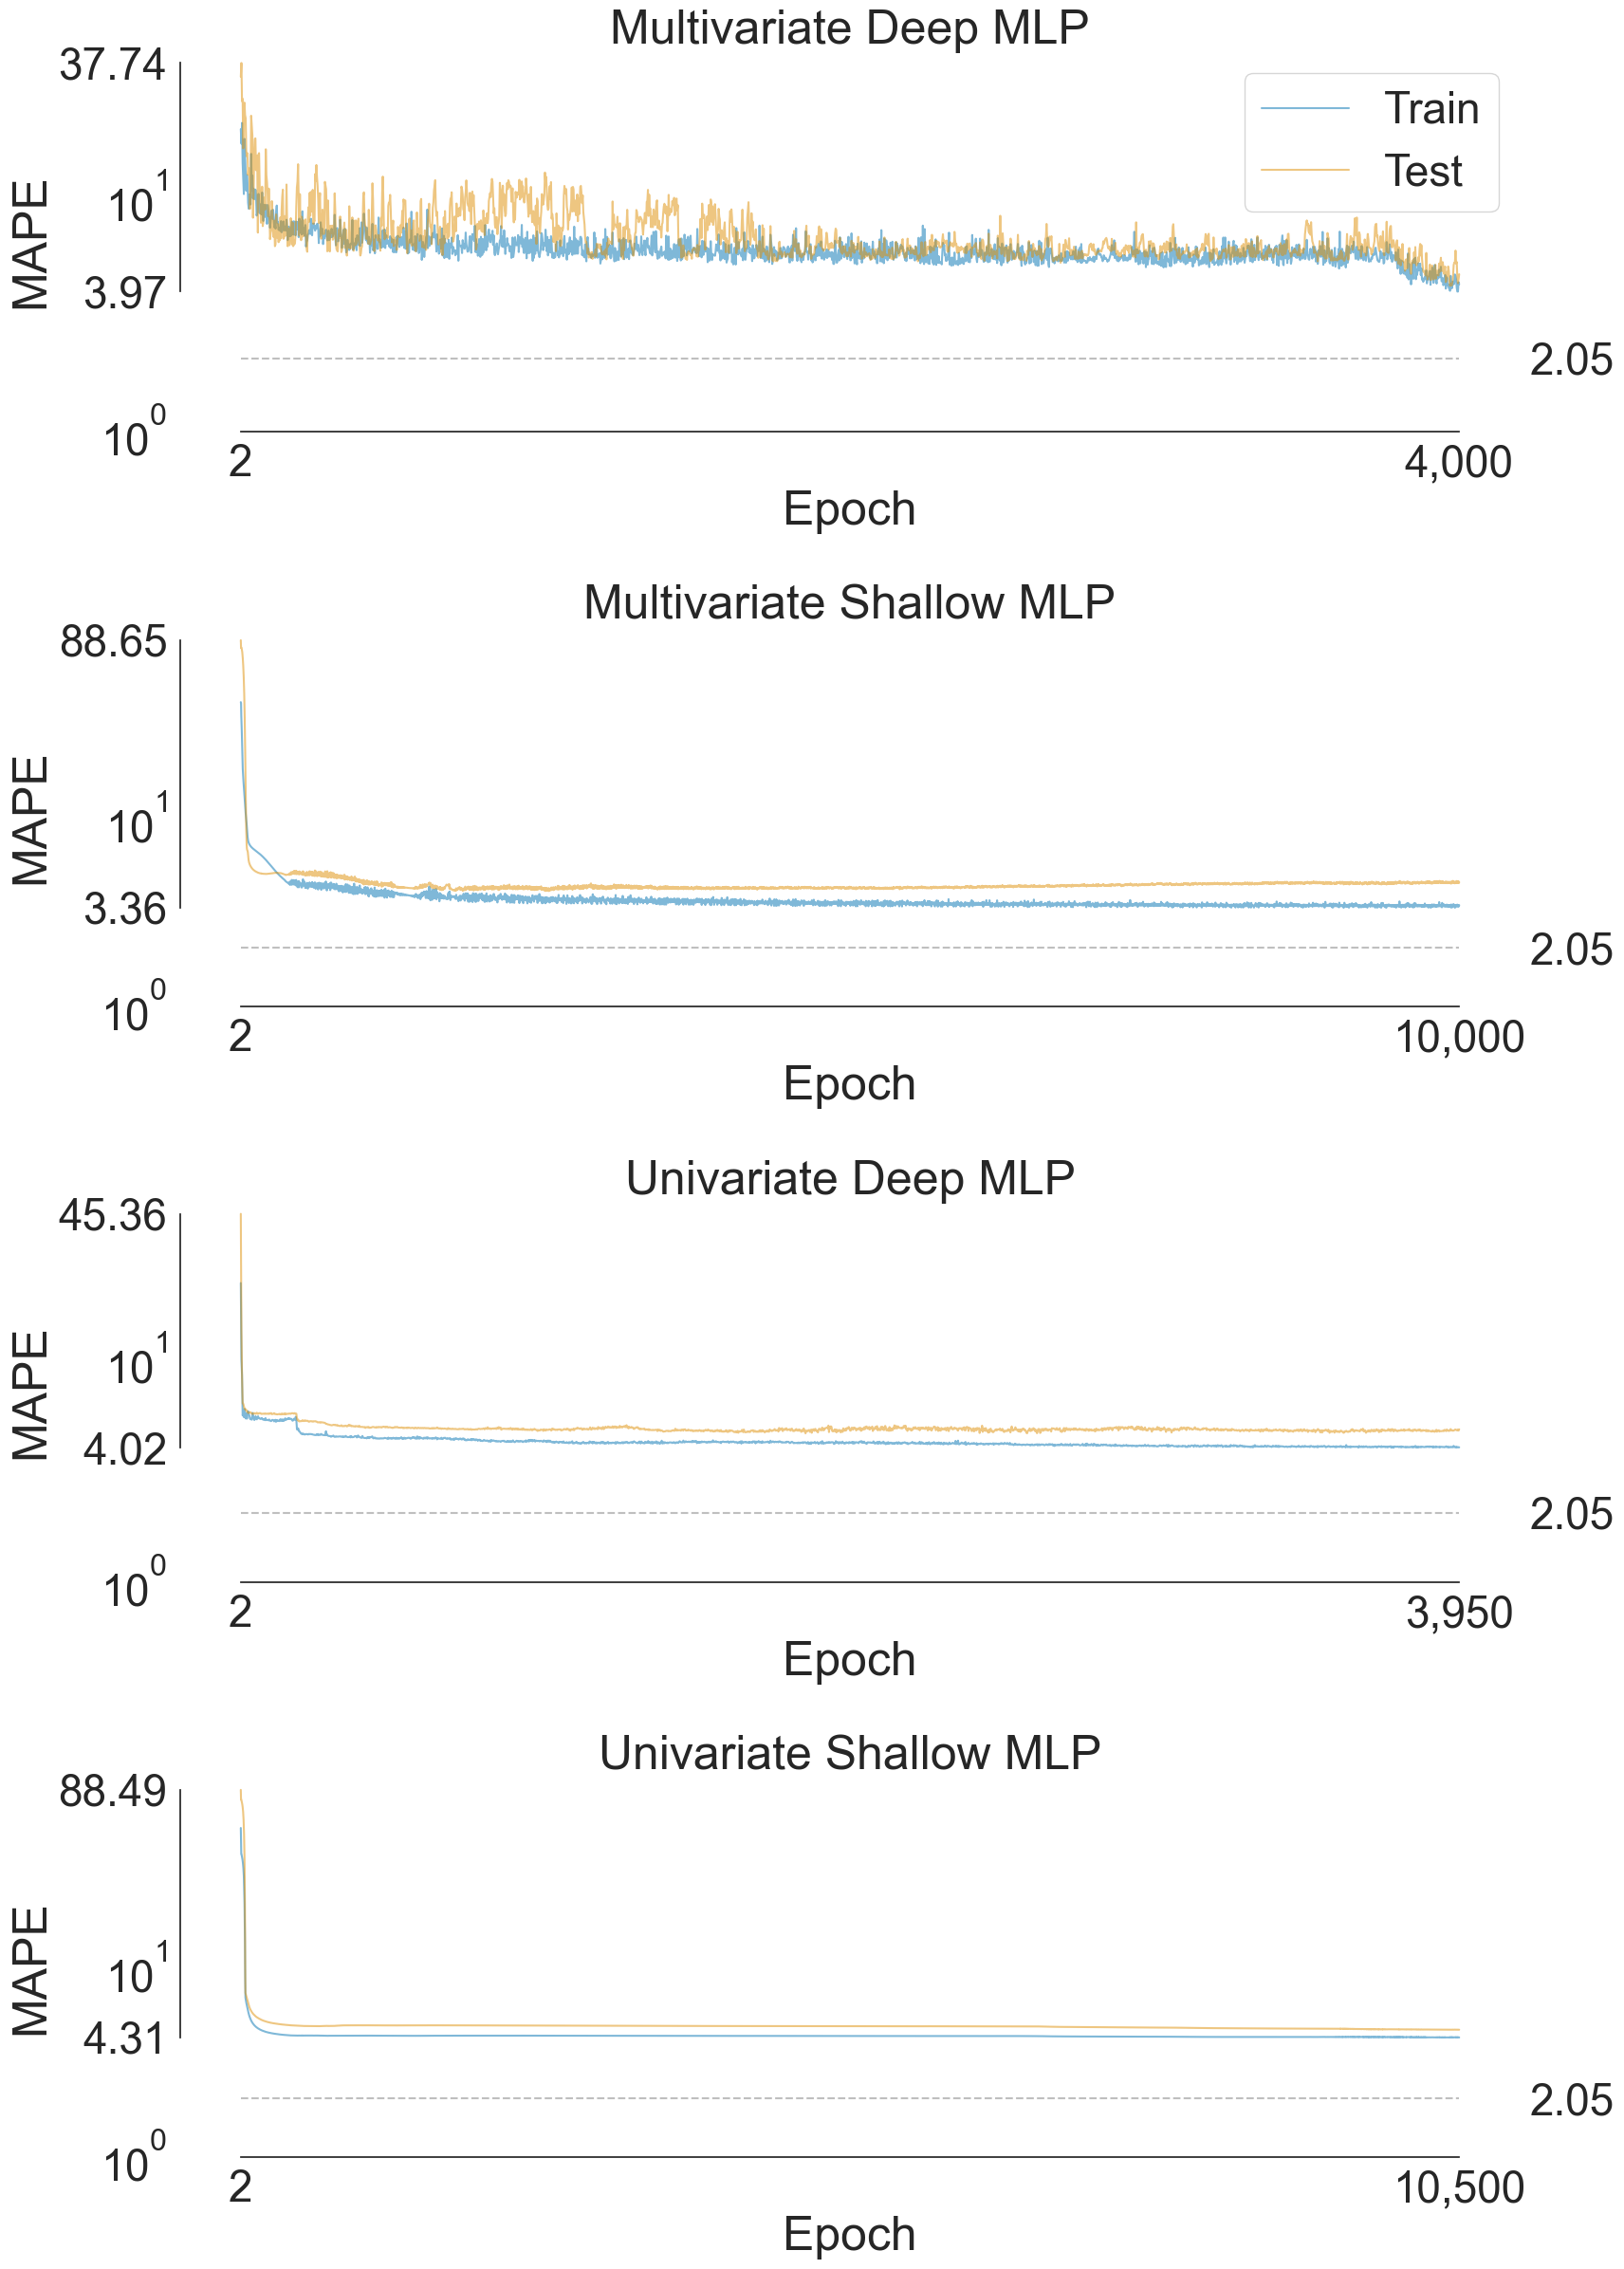

In [179]:
mdls = ['MLP', 'BD-LSTM']
mlp_hists, lstm_hists = [
    [(k, v) for k, v in sorted(label_hists.items()) if mdl in k] 
    for mdl in mdls
]

def plot_mhists(m_hists, filename=None):
    n_rows, n_cols = len(m_hists), 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18*n_cols, 6.2*n_rows))
    colours = palette(2)
    
    for i, (m, m_hist) in enumerate(m_hists):
        ax = axes[i]
        mse_cols = [e for e in m_hist.columns if 'mean_squared_error' in e]
        m_hist[[e.replace('mean_squared_error', 'RMSE') for e in mse_cols]] = m_hist[mse_cols].apply(lambda d: d.apply(lambda e: e**.5), axis=1)
        m_hist = m_hist.iloc[1::2]
        
        # metrics = ['loss', 'RMSE']
        
        # for i, ax in enumerate(ax_row):
        
        metric = 'loss' #metrics[i]
        label = metric.replace('loss', 'MAPE')

        sns.lineplot(m_hist, x='epoch', y=metric, ax=ax, label='Train', alpha=0.5, c=colours[0])
        sns.lineplot(m_hist, x='epoch', y=f"val_{metric}", ax=ax, label='Test', alpha=0.5, c=colours[1])
    
        ax.set_yscale('log')

        ax.set_xlabel('Epoch')
        ax.set_ylabel(label)
        ax.set_title(m)

        # x_mid = round(m_hist.epoch.max() / 20) * 10
        neaten_ticks(ax, 'x', [m_hist.epoch.min(), m_hist.epoch.max()], [], commas=True)
        if metric == 'RMSE':
            ax.set_ylim(100)
            additional_yticks = [100, 1000]  
        else:
            ax.set_ylim(1)
            additional_yticks = [1, 10]
        y_min = min(m_hist[f"val_{metric}"].min(), m_hist[metric].min())
        y_max = max(m_hist[f"val_{metric}"].max(), m_hist[metric].max())
        neaten_ticks(ax, 'y', [y_min, y_max], additional_yticks, dp= 2 if label == 'MAPE' else 0)

        ax.tick_params(axis='both', color='white')

        if i > 0:
            ax.get_legend().remove()

        ax.yaxis.set_minor_locator(ticker.FixedLocator([aspr_MAPE]))
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%.2f"))
        ax.tick_params(axis='y', which='minor', labelleft=False, labelright=True)
        ax.hlines([aspr_MAPE], 2,  max(ax.get_xticks()), color='grey', ls='--', alpha=0.5)
        
    show(fig, axes.flatten(), True, file=filename, legend_loc=1)

plot_mhists(mlp_hists, f'MLP training histories')


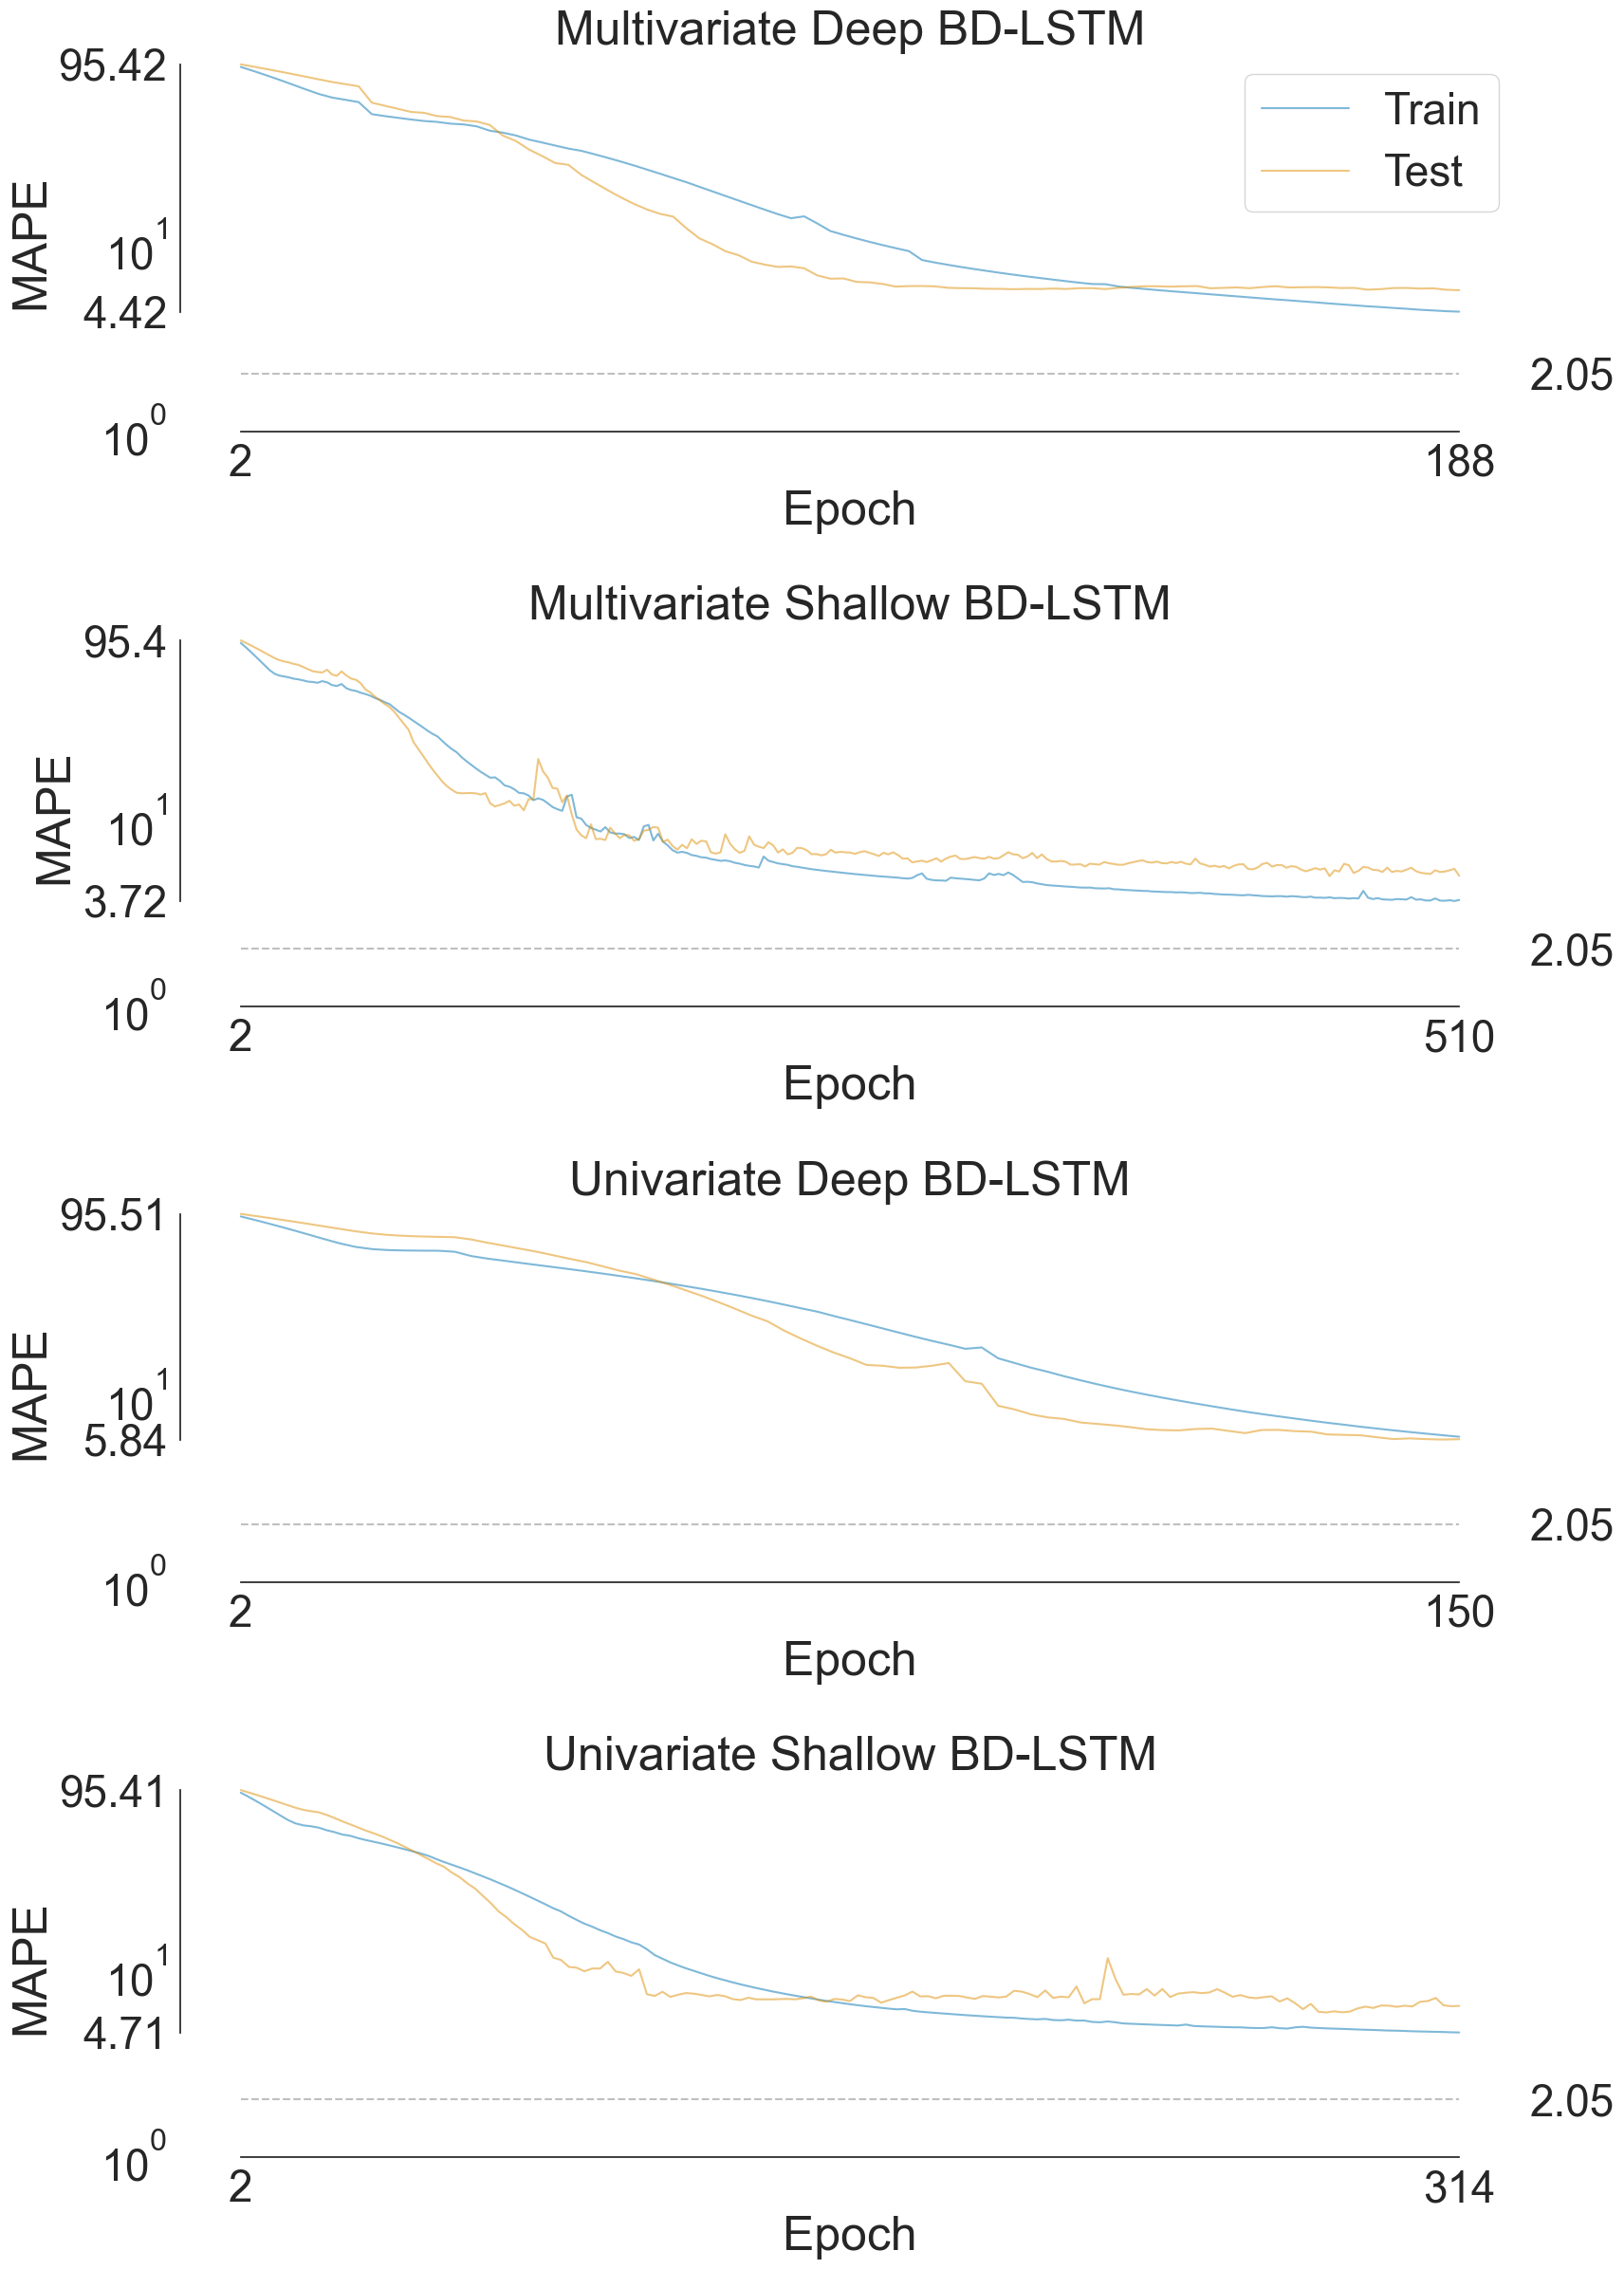

In [180]:
plot_mhists(lstm_hists, f'BD-LSTM training histories')


In [183]:
2**8

256

# Test results


In [11]:
tests = pd.read_csv('Results/model test results.csv')\
    .sort_values('test_MAPE').rename(columns={
        'test_MAPE': 'MAPE_avg', 'test_RMSE': 'RMSE_avg'
    })
tests.columns = [e.replace('test_', '') for e in tests.columns]
tests.model = tests.model.apply(to_model_label)

horizons = sorted({e.split('_')[1] for e in tests.columns if '_' in e})
metrics = sorted({e.split('_')[0] for e in tests.columns if '_' in e})

tests


,model,MAPE_avg,RMSE_avg,MAPE_1H,RMSE_1H,MAPE_24H,RMSE_24H
0,Multivariate Shallow MLP,4.592746,344.251339,2.454829,157.533066,6.730966,460.652405
7,Univariate Deep MLP,4.641925,395.710240,1.972130,127.788162,7.312287,544.833740
4,Multivariate Deep MLP,4.703630,373.064715,2.553428,166.318390,6.853806,500.692932
6,Univariate Shallow MLP,4.716120,416.986436,1.776844,119.280052,7.656026,577.518677
1,Multivariate Shallow BD-LSTM,5.072569,403.694114,2.682200,189.882523,7.463651,538.406799
3,Multivariate Deep BD-LSTM,5.683590,431.440049,3.377848,218.846603,7.989808,569.550476
5,Univariate Deep BD-LSTM,5.837089,449.414741,3.209659,223.817490,8.465214,594.855347
2,Univariate Shallow BD-LSTM,6.017723,453.967854,3.748036,241.104172,8.288210,595.014832


In [12]:
def get_metric_renamer(mt_cols, troubleshoot=False):
    tbl_cols = ['1 Hour', '24 Hour', 'Mean']
    rename_dict = dict(zip(mt_cols, tbl_cols))
    if troubleshoot:
        print(rename_dict)
    return rename_dict
    
for mt in metrics:
    mt_cols = sorted([e for e in tests.columns if mt in e])
    mt_tex = tests.set_index('model').sort_index(axis=1)[mt_cols].reset_index()\
        .rename(columns={'model': 'Model', **get_metric_renamer(mt_cols)})\
        .style\
        .hide()\
        .format("{:.02f}", subset=['1 Hour', '24 Hour', 'Mean'])\
        .to_latex(
            label=mt.lower(), position_float="centering", hrules=True, position='H',
            caption = f"{mt} test results for the eight models. The tests covered the one- and 24-hour ahead prediction horizons and their batch-wise mean. The models are ordered by the mean."
        )

    mt_tex = sub(r'(?s)(^.*)(\\caption{.*?}\n\\label{.*?}\n)(.*)(\\end{table})', r'\1\3\2\4', mt_tex)
    print(mt_tex)
    
    with open(f"{tbl_dir}model {mt}s.tex", 'w') as f:
        f.write(mt_tex)


\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Model & 1 Hour & 24 Hour & Mean \\
\midrule
Multivariate Shallow MLP & 2.45 & 6.73 & 4.59 \\
Univariate Deep MLP & 1.97 & 7.31 & 4.64 \\
Multivariate Deep MLP & 2.55 & 6.85 & 4.70 \\
Univariate Shallow MLP & 1.78 & 7.66 & 4.72 \\
Multivariate Shallow BD-LSTM & 2.68 & 7.46 & 5.07 \\
Multivariate Deep BD-LSTM & 3.38 & 7.99 & 5.68 \\
Univariate Deep BD-LSTM & 3.21 & 8.47 & 5.84 \\
Univariate Shallow BD-LSTM & 3.75 & 8.29 & 6.02 \\
\bottomrule
\end{tabular}
\caption{MAPE test results for the eight models. The tests covered the one- and 24-hour ahead prediction horizons and their batch-wise mean. The models are ordered by the mean.}
\label{mape}
\end{table}

\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Model & 1 Hour & 24 Hour & Mean \\
\midrule
Multivariate Shallow MLP & 157.53 & 460.65 & 344.25 \\
Univariate Deep MLP & 127.79 & 544.83 & 395.71 \\
Multivariate Deep MLP & 166.32 & 500.69 & 373.06 \\
Univariate Shallow 

In [70]:
for mt in metrics:

    mt_cols = sorted([e for e in tests.columns if mt in e])
    test_ranks = tests.set_index('model')[mt_cols].rank().astype(int)
    
    test_ranks['Mean Rank'] = test_ranks.mean(axis=1)
    
    test_ranks = test_ranks.reset_index()\
        .sort_values('Mean Rank')\
        .rename(columns={'model': 'Model', **get_metric_renamer(mt_cols)})
    
    tranks_tex = test_ranks.style.hide()\
        .format("{:.02f}", subset=['Mean Rank'])\
        .to_latex(
                label=f'{mt.lower()}-ranks', position_float="centering", hrules=True, position='H',
                caption = f"Ranking by {mt} results for the eight models. The tests covered the one- and 24-hour ahead prediction horizons and their batch-wise mean. The models are ordered by their mean ranking."
            )
    
    tranks_tex = sub(r'(?s)(^.*)(\\caption{.*?}\n\\label{.*?}\n)(.*)(\\end{table})', r'\1\3\2\4', tranks_tex)
    tranks_tex = sub(r'{lrrrr}', r'{lrrr|r}', tranks_tex)
    
    print(tranks_tex)
    
    with open(f"{tbl_dir}model {mt} ranks.tex", 'w') as f:
        f.write(tranks_tex)
    


\begin{table}[H]
\centering
\begin{tabular}{lrrr|r}
\toprule
Model & 1 Hour & 24 Hour & Mean & Mean Rank \\
\midrule
Multivariate Shallow MLP & 3 & 1 & 1 & 1.67 \\
Univariate Deep MLP & 2 & 3 & 2 & 2.33 \\
Multivariate Deep MLP & 4 & 2 & 3 & 3.00 \\
Univariate Shallow MLP & 1 & 5 & 4 & 3.33 \\
Multivariate Shallow BD-LSTM & 5 & 4 & 5 & 4.67 \\
Multivariate Deep BD-LSTM & 7 & 6 & 6 & 6.33 \\
Univariate Deep BD-LSTM & 6 & 8 & 7 & 7.00 \\
Univariate Shallow BD-LSTM & 8 & 7 & 8 & 7.67 \\
\bottomrule
\end{tabular}
\caption{Ranking by MAPE results for the eight models. The tests covered the one- and 24-hour ahead prediction horizons and their batch-wise mean. The models are ordered by their mean ranking.}
\label{mape-ranks}
\end{table}

\begin{table}[H]
\centering
\begin{tabular}{lrrr|r}
\toprule
Model & 1 Hour & 24 Hour & Mean & Mean Rank \\
\midrule
Multivariate Shallow MLP & 3 & 1 & 1 & 1.67 \\
Multivariate Deep MLP & 4 & 2 & 2 & 2.67 \\
Univariate Deep MLP & 2 & 4 & 3 & 3.00 \\
Univariat

In [71]:
test_ranks


,Model,1 Hour,24 Hour,Mean,Mean Rank
0,Multivariate Shallow MLP,3,1,1,1.666667
2,Multivariate Deep MLP,4,2,2,2.666667
1,Univariate Deep MLP,2,4,3,3.000000
3,Univariate Shallow MLP,1,6,5,4.000000
4,Multivariate Shallow BD-LSTM,5,3,4,4.000000
5,Multivariate Deep BD-LSTM,6,5,6,5.666667
6,Univariate Deep BD-LSTM,7,7,7,7.000000
7,Univariate Shallow BD-LSTM,8,8,8,8.000000


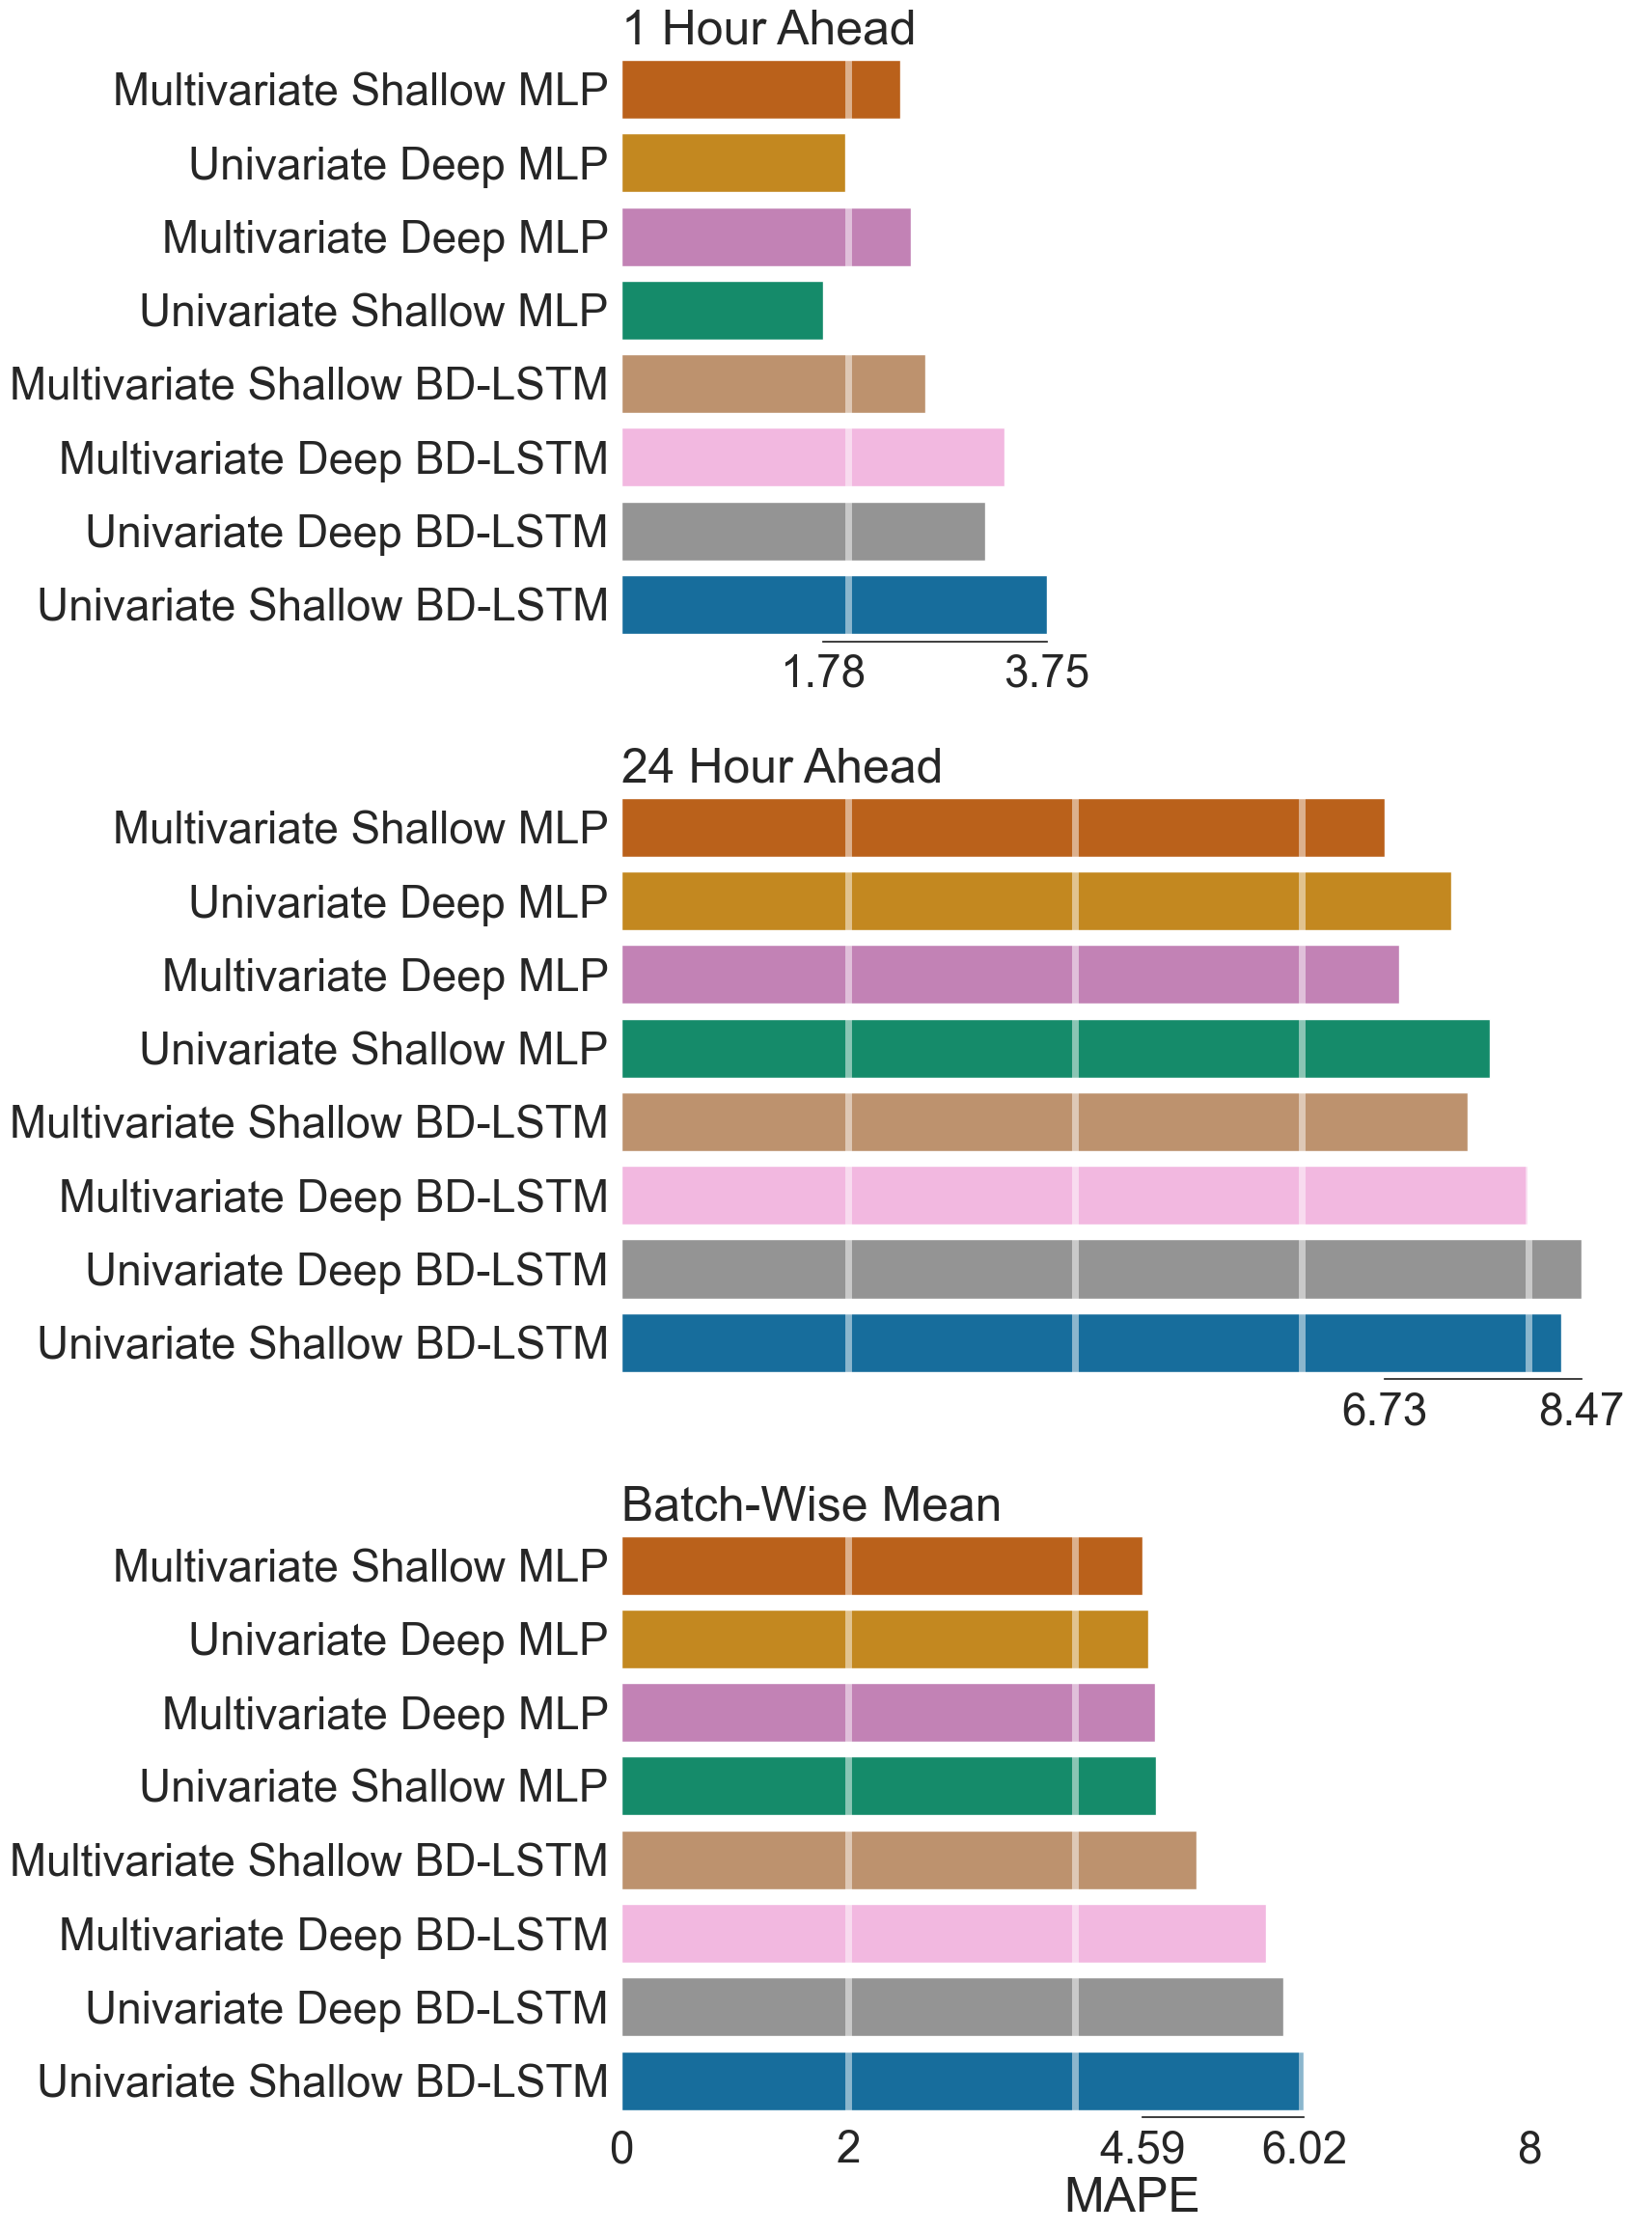

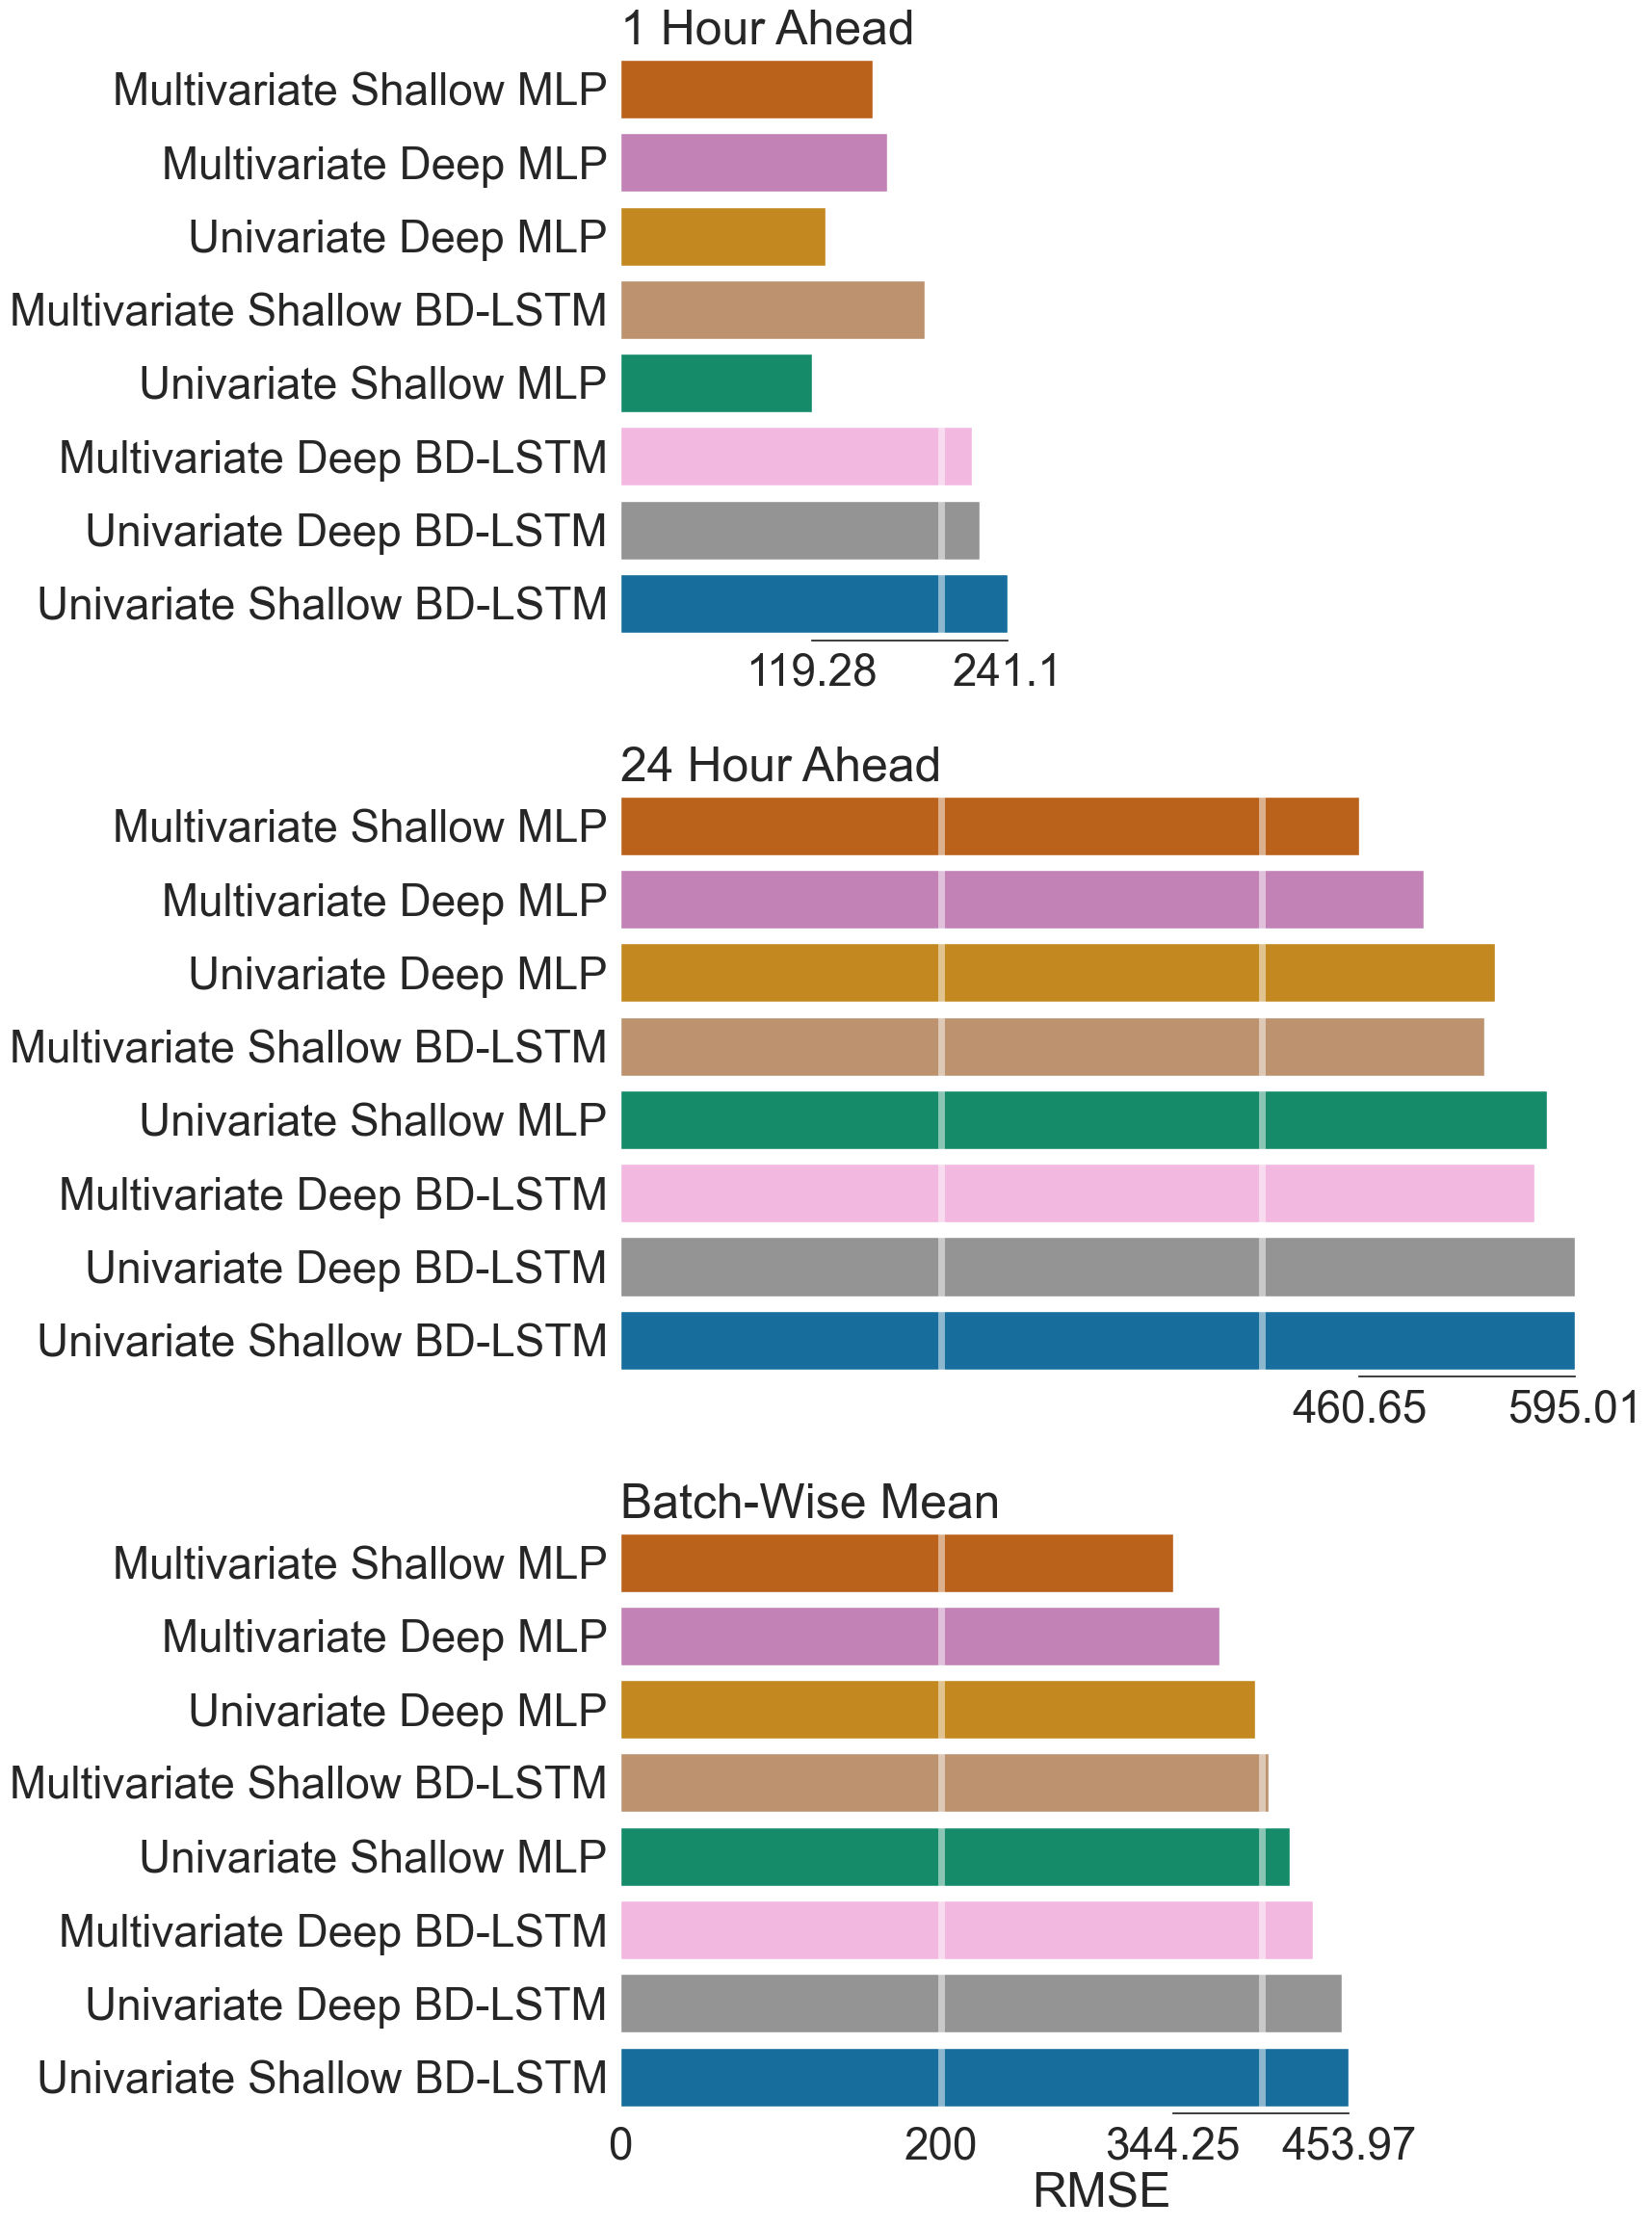

In [66]:
sns.set_theme(style='white', font_scale=3)
mdl_colour_mapper = mdl_colour_mapper = dict(zip([to_model_label(e) for e in models], palette(len(models))))

def plot_results(tests, metric):
    data = pd.merge(tests.copy(), model_colours, how='left', on='model')
    n_cols, n_rows = 1, len(horizons)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18*n_cols, 8*n_rows))
    
    for i, hrz in enumerate(horizons):
        ax = axes[i]
        metric_col = f"{metric}_{hrz}"
        sns.barplot(
            tests.sort_values(f"{metric}_avg"), x=metric_col, y='model', hue='model', 
            ax=ax, palette=mdl_colour_mapper
        )
    
        ax.tick_params(axis='both', color='white')
        ax.spines['left'].set_visible(False)
    
        ax.set_ylabel('')
        ax.set_title(hrz.replace('H' ,' hour ahead').replace('avg', 'Batch-wise mean').title(), loc='left')
    
        if metric == 'MAPE':
            x_ticks = [0, 2, 8]
            x_grid = [2, 4, 6, 8]
            ax.set_xlim(0, 9)
        else:
            x_ticks = [0, 200]
            x_grid = [200, 400]
            ax.set_xlim(0, 600)

        if i+1 < n_rows:
            ax.set_xlabel('')
            x_ticks = []
        else:
            ax.set_xlabel(metric)
            
    
        neaten_ticks(ax, 'x', [tests[metric_col].min(), tests[metric_col].max()], x_ticks, dp=2)
    
        for line in x_grid:
            ax.axvline(line, 0, max(ax.get_xticks()), color='white', alpha=0.5, lw=5)
    
    show(fig, axes, True, file=f'Test {metric} results')

plot_results(tests, 'MAPE')
plot_results(tests, 'RMSE')
